In [1]:
__author__ = "Brad Rice"
__version__ = 0.1

In [2]:
import os
import datetime

from tqdm import tqdm

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.OpticalFlowUtils import FlowReader
from utils.OpticalFlowUtils import FlowVisualiser

from utils.MPISintelUtils import MPISintelHandler

from assets.ml.src.CustomLosses import EPE_Loss
from assets.ml.src.POIFE_model import POIFE_TrunkNET
from assets.ml.src.POIFE_model import POIFE_BranchNET
from assets.ml.src.POIFE_model import OpticalFlowOperatorNetwork

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 8.1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8.1)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(f"Runtime Error: {e}")

1 Physical GPUs, 1 Logical GPUs


In [4]:
reader = FlowReader()
visualiser = FlowVisualiser()
dataHandler = MPISintelHandler()

In [5]:
SINTEL_PATH = os.path.join("..", "Data", "MPI-Sintel")
SINTEL_TRAINING_PATH = os.path.join(SINTEL_PATH, "training")
SINTEL_TRAINING_FLOW_PATH = os.path.join(SINTEL_TRAINING_PATH, "flow")
SINTEL_TRAINING_IMG_PATH = os.path.join(SINTEL_TRAINING_PATH, "clean")

In [6]:
print(f"SINTEL PATH: {SINTEL_PATH}")
print(f"SINTEL TRAINING PATH: {SINTEL_TRAINING_PATH}")
print(f"SINTEL TRAINING FLOW PATH: {SINTEL_TRAINING_FLOW_PATH}")
print(f"SINTEL TRAINING IMG PATH: {SINTEL_TRAINING_IMG_PATH}")

SINTEL PATH: ..\Data\MPI-Sintel
SINTEL TRAINING PATH: ..\Data\MPI-Sintel\training
SINTEL TRAINING FLOW PATH: ..\Data\MPI-Sintel\training\flow
SINTEL TRAINING IMG PATH: ..\Data\MPI-Sintel\training\clean


In [7]:
# Load the split data 
dataFilepath = os.path.join(".", "assets", "data", "trainX.data")
train_X = dataHandler.loadData(dataFilepath)
train_X = train_X.astype('float32') / 255.0
train_X = tf.reshape(train_X, shape=(-1, 2, 436, 1024, 1))

dataFilepath = os.path.join(".", "assets", "data", "testX.data")
test_X = dataHandler.loadData(dataFilepath)
test_X = test_X.astype('float32') / 255.0
test_X = tf.reshape(test_X, shape=(-1, 2, 436, 1024, 1))

dataFilepath = os.path.join(".", "assets", "data", "valX.data")
val_X = dataHandler.loadData(dataFilepath)
val_X = val_X.astype('float32') / 255.0
val_X = tf.reshape(val_X, shape=(-1, 2, 436, 1024, 1))

dataFilepath = os.path.join(".", "assets", "data", "trainy.data")
train_y = dataHandler.loadData(dataFilepath)
train_y = train_y.astype('float32')

dataFilepath = os.path.join(".", "assets", "data", "testy.data")
test_y = dataHandler.loadData(dataFilepath)
test_y = test_y.astype('float32')

dataFilepath = os.path.join(".", "assets", "data", "valy.data")
val_y = dataHandler.loadData(dataFilepath)
val_y = val_y.astype('float32')

print(f"train_X: {train_X.shape} test_X: {test_X.shape} val_X: {val_X.shape} -> Total Samples: {train_X.shape[0] + test_X.shape[0] + val_X.shape[0]}")
print(f"train_y: {train_y.shape} test_y: {test_y.shape} val_y: {val_y.shape} -> Total Samples: {train_y.shape[0] + test_y.shape[0] + val_y.shape[0]}")

train_X: (510, 2, 436, 1024, 1) test_X: (297, 2, 436, 1024, 1) val_X: (234, 2, 436, 1024, 1) -> Total Samples: 1041
train_y: (510, 436, 1024, 2) test_y: (297, 436, 1024, 2) val_y: (234, 436, 1024, 2) -> Total Samples: 1041


In [8]:
index = 60
grid = []
for i in range(train_X.shape[2]):
    for j in range(train_X.shape[3]):
        grid.append(np.array([i/435.0, j/1023.0]))
        # grid.append(np.array([train_X[index, 0, i, j], train_X[index, 1, i, j]]))

grid = np.array(grid)
print(grid)
print(grid.shape)

[[[0.54509807]
  [0.5803922 ]]

 [[0.57254905]
  [0.60784316]]

 [[0.5921569 ]
  [0.60784316]]

 ...

 [[0.11764706]
  [0.12941177]]

 [[0.12156863]
  [0.13333334]]

 [[0.12941177]
  [0.13333334]]]
(446464, 2, 1)


In [9]:
grid = grid.reshape(-1, 2)
grid.shape

(446464, 2)

In [10]:
print(train_y[index])
print(train_y[index].shape)

[[[-1.7766203e+00  1.7668789e-03]
  [-1.7731352e+00  2.4507607e-03]
  [-1.7696549e+00  3.1345182e-03]
  ...
  [-1.3367876e+00  5.9720623e-01]
  [-1.3386788e+00  5.9773785e-01]
  [-1.3405734e+00  5.9826946e-01]]

 [[-1.7770587e+00  2.5444005e-03]
  [-1.7735730e+00  3.2260560e-03]
  [-1.7700919e+00  3.9077145e-03]
  ...
  [-1.3366110e+00  5.9608215e-01]
  [-1.3385018e+00  5.9661216e-01]
  [-1.3403958e+00  5.9714204e-01]]

 [[-1.7774969e+00  3.3232025e-03]
  [-1.7740109e+00  4.0026368e-03]
  [-1.7705290e+00  4.6820869e-03]
  ...
  [-1.3364347e+00  5.9495944e-01]
  [-1.3383248e+00  5.9548765e-01]
  [-1.3402182e+00  5.9601593e-01]]

 ...

 [[-2.1584694e+00  4.6100831e-01]
  [-2.1564279e+00  4.6080053e-01]
  [-2.1543894e+00  4.6059260e-01]
  ...
  [-1.6073767e+00  2.4332882e-01]
  [-1.6086549e+00  2.4311461e-01]
  [-1.6099572e+00  2.4289025e-01]]

 [[-2.1591637e+00  4.6238038e-01]
  [-2.1571212e+00  4.6217084e-01]
  [-2.1550822e+00  4.6196124e-01]
  ...
  [-1.6073154e+00  2.4288486e-01]
  [-

In [11]:
flow = train_y[index]
print(flow.reshape(436*1024, 2))
print(flow.reshape(436*1024, 2).shape)

[[-1.7766203e+00  1.7668789e-03]
 [-1.7731352e+00  2.4507607e-03]
 [-1.7696549e+00  3.1345182e-03]
 ...
 [-1.6072540e+00  2.4244004e-01]
 [-1.6085391e+00  2.4222893e-01]
 [-1.6098360e+00  2.4200349e-01]]
(446464, 2)


In [17]:
deepONET = OpticalFlowOperatorNetwork()

deepONET.build(input_shape=[(None, 2, 436, 1024, 1), (None, 2)])
deepONET.summary()

Model: "optical_flow_operator_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 poife__branch_net (POIFE_B  multiple                  12585418  
 ranchNET)                                                       
                                                                 
 poife__trunk_net (POIFE_Tr  multiple                  1545050   
 unkNET)                                                         
                                                                 
 bias_layer (BiasLayer)      multiple                  1         
                                                                 
 bias_layer_1 (BiasLayer)    multiple                  1         
                                                                 
Total params: 14130470 (53.90 MB)
Trainable params: 14125542 (53.88 MB)
Non-trainable params: 4928 (19.25 KB)
___________________________________________________________

In [21]:
first = tf.reshape(train_X[index], shape = (1, 2, 436, 1024, 1))

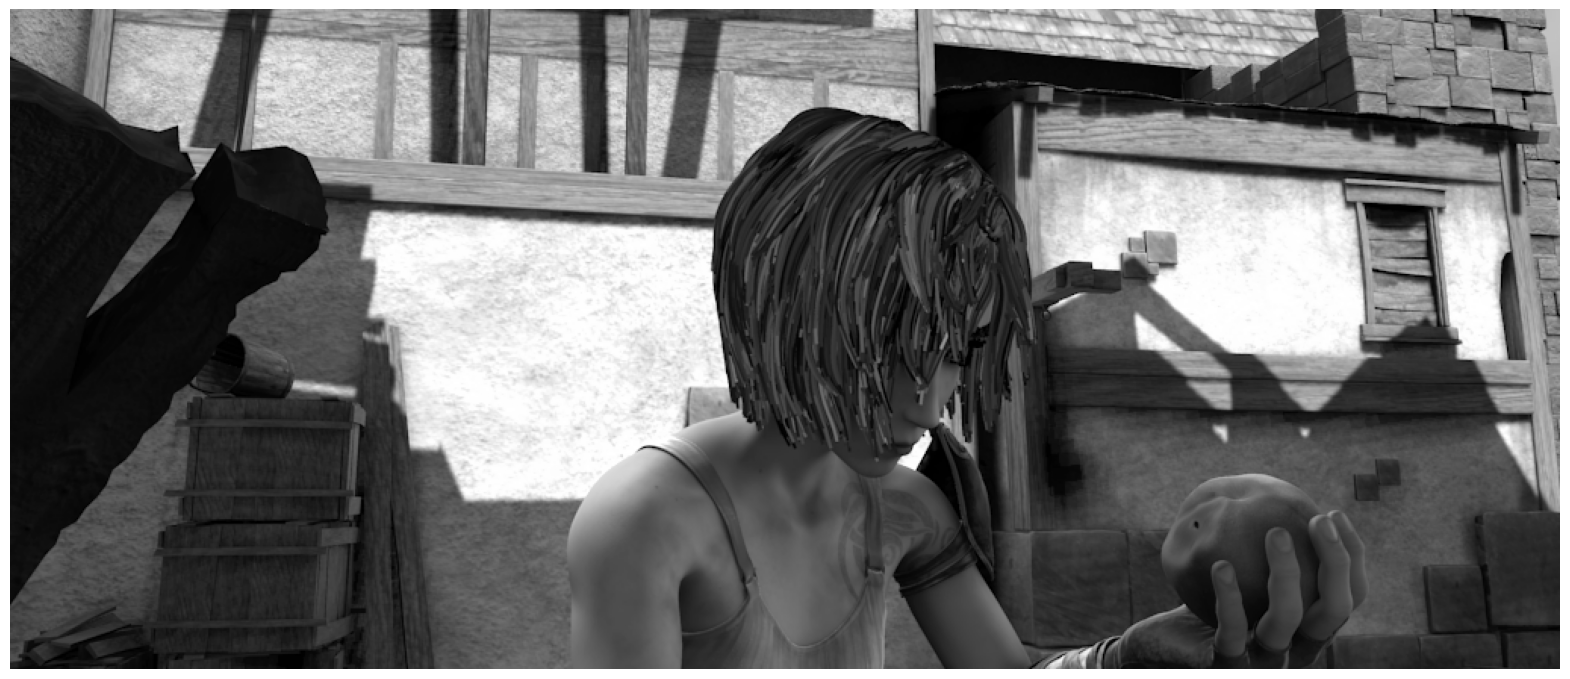

In [13]:
visualiser.imshow(train_X[index].numpy()[0])

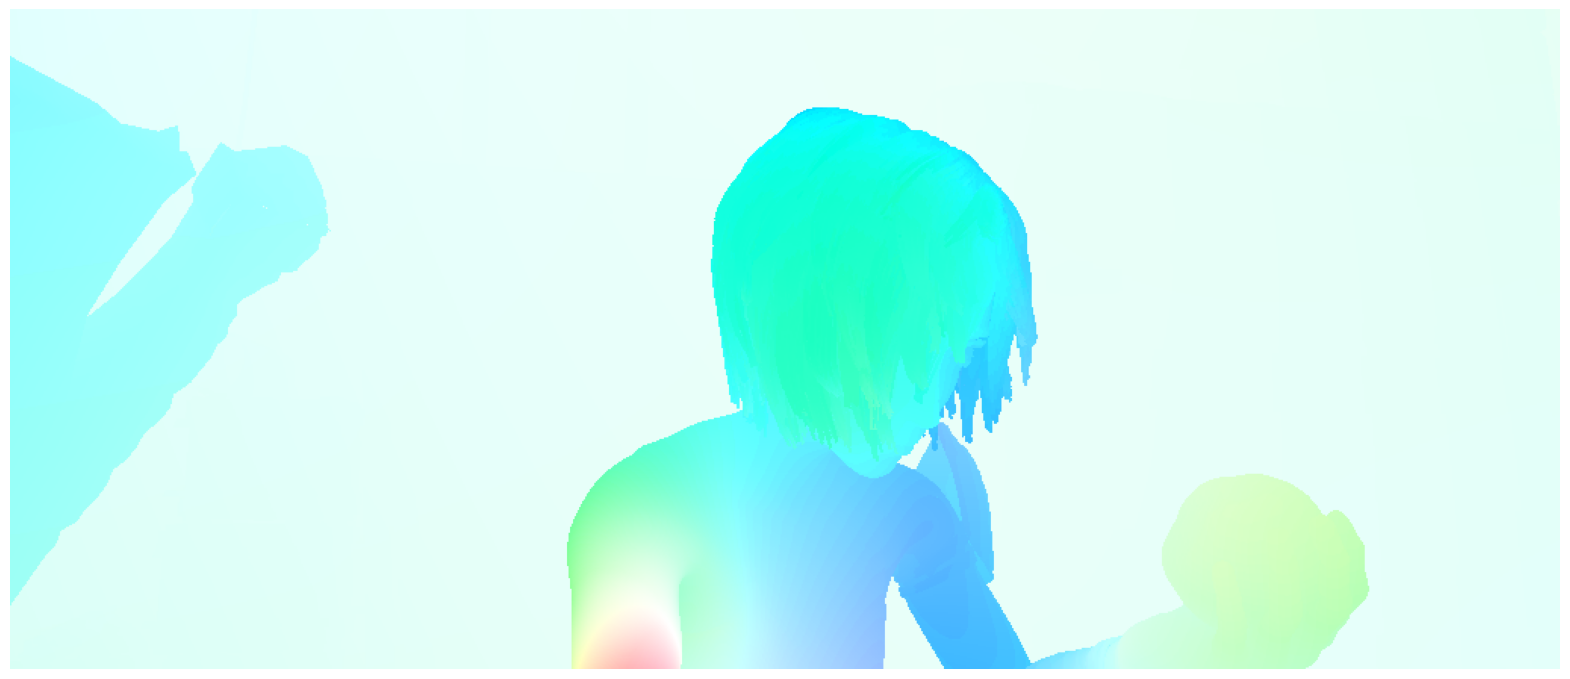

In [14]:
visualiser.visualiseOpticalFlow(train_y[index])

In [21]:
preds = []
for i in range(436):
    for j in range(1024):
        x = i / 435.0
        y = j / 1024.0
        print(f"{i+1}/{436}, {j+1}/{1024}", end = '\r')
        out = deepONET([first, np.array([x, y]).reshape(1, 2)])
        preds.append(out.numpy().ravel())

preds = np.array(preds)
print(preds.shape)

preds = preds.reshape(436, 1024, 2)
print(preds)

(446464, 2)24/1024
[[[ 0.00000000e+00  0.00000000e+00]
  [-1.06569883e-06  1.03230036e-06]
  [-2.13139765e-06  2.06460072e-06]
  ...
  [-1.05121033e-03  9.97041934e-04]
  [-1.05217216e-03  9.97913885e-04]
  [-1.05313270e-03  9.98787000e-04]]

 [[ 4.92135968e-08  2.34896277e-07]
  [-1.01648652e-06  1.26719578e-06]
  [-2.08218285e-06  2.29949660e-06]
  ...
  [-1.05113816e-03  9.97289317e-04]
  [-1.05209916e-03  9.98162432e-04]
  [-1.05306040e-03  9.99034615e-04]]

 [[ 9.84278330e-08  4.69794372e-07]
  [-9.67266942e-07  1.50209235e-06]
  [-2.03296668e-06  2.53438975e-06]
  ...
  [-1.05106481e-03  9.97536583e-04]
  [-1.05202664e-03  9.98409232e-04]
  [-1.05298753e-03  9.99281765e-04]]

 ...

 [[ 2.47447751e-05  1.05623527e-04]
  [ 2.37292606e-05  1.06629530e-04]
  [ 2.27143119e-05  1.07635162e-04]
  ...
  [-9.71315661e-04  1.08523061e-03]
  [-9.72224516e-04  1.08609907e-03]
  [-9.73133894e-04  1.08696695e-03]]

 [[ 2.48171254e-05  1.05883366e-04]
  [ 2.38021676e-05  1.06889362e-04]
  [ 2.2

In [12]:
preds.shape

NameError: name 'preds' is not defined

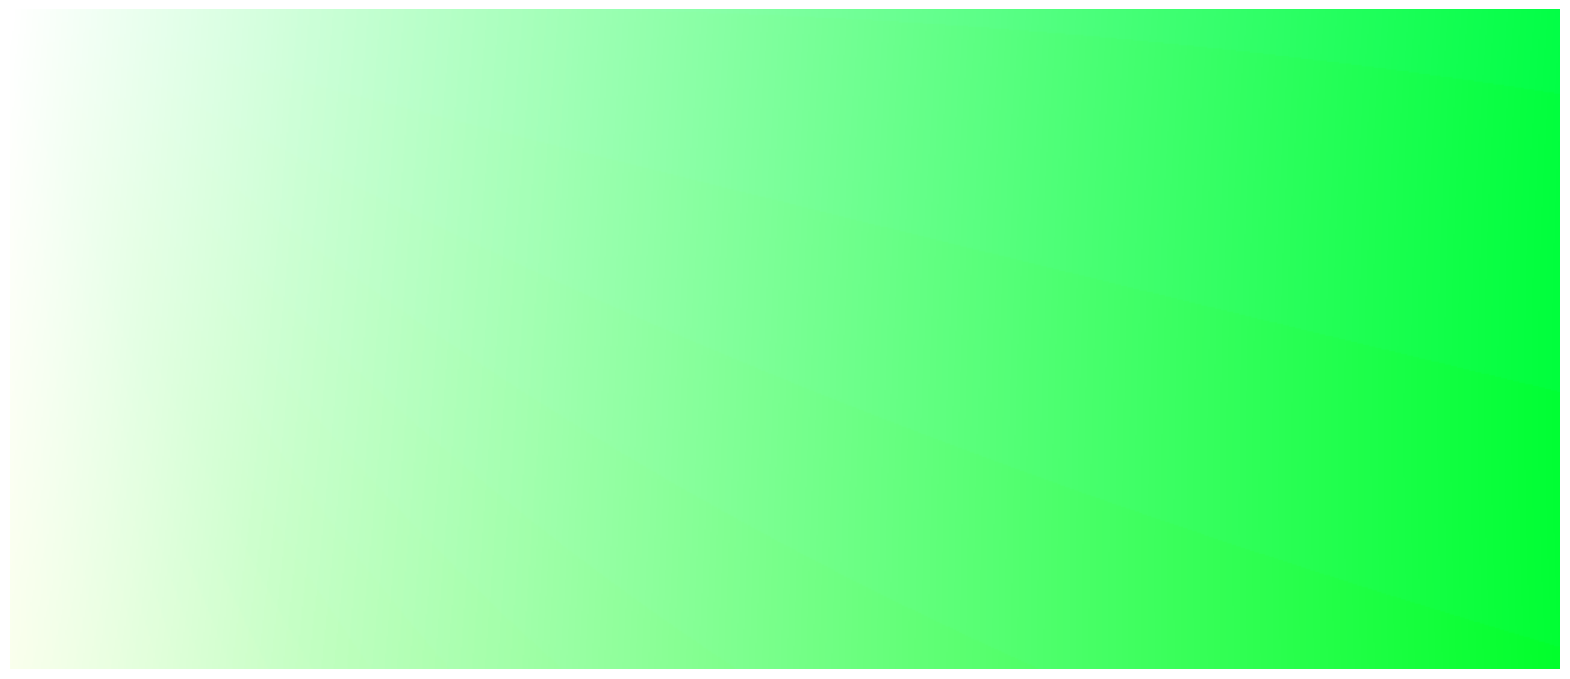

In [23]:
visualiser.visualiseOpticalFlow(preds)

In [12]:
imageGrid = []
for i in range(436):
    for j in range(1024):
        imageGrid.append(np.array([i/435.0, j/1023.0]))

imageGrid = np.array(imageGrid)

In [22]:
first_broadcasted = tf.broadcast_to(first, (1024, 2, 436, 1024, 1))
print(first_broadcasted.shape)

(1024, 2, 436, 1024, 1)


In [27]:
out = deepONET.predict([first_broadcasted, imageGrid[0:1024]], batch_size=256, verbose = True)
print(out.shape)

2/2 [==============================] - 589s 334s/step
(1024, 2)


In [28]:
out

array([[ 0.0000000e+00,  0.0000000e+00],
       [-3.4503404e-07, -1.3275513e-06],
       [-6.9006592e-07, -2.6550988e-06],
       ...,
       [-3.4511453e-04, -1.2550144e-03],
       [-3.4543686e-04, -1.2560620e-03],
       [-3.4575898e-04, -1.2571065e-03]], dtype=float32)

In [29]:
preds = []
for i in tqdm(range(436)):
    row  = grid[i*1024:(i+1)*1024]
    out = deepONET.predict([first_broadcasted, row], batch_size=16, verbose = True)
    preds.append(out)

preds = np.array(preds)
print(preds.shape)

preds = preds.reshape(436, 1024, 2)
print(preds)

  0%|          | 0/436 [00:00<?, ?it/s]

64/64 [==============================] - 215s 3s/step


  0%|          | 1/436 [03:35<26:00:26, 215.23s/it]

64/64 [==============================] - 261s 4s/step


  0%|          | 2/436 [07:57<29:16:28, 242.83s/it]

64/64 [==============================] - 219s 3s/step


  1%|          | 3/436 [11:37<27:55:57, 232.23s/it]

64/64 [==============================] - 224s 3s/step


  1%|          | 4/436 [15:21<27:29:23, 229.08s/it]

12/64 [====>.........................] - ETA: 2:54

  1%|          | 4/436 [16:06<29:00:03, 241.67s/it]


KeyboardInterrupt: 

In [15]:
def visualiseFits(fits, validationData = True):
    fig, axs = plt.subplots(2, 2, figsize = (40, 20))

    axs[0][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[0][0].set_xlabel("Epochs")
    axs[0][0].set_ylabel("EPE (log Scaled)")
    axs[0][0].set_yscale('log')
    axs[0][0].grid(True)

    axs[1][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[1][0].set_xlabel("Epochs")
    axs[1][0].set_ylabel("EPE")
    axs[1][0].grid(True)

    axs[0][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[0][1].set_xlabel("Epochs")
    axs[0][1].set_ylabel("MSE")
    axs[0][1].grid(True)

    axs[1][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[1][1].set_xlabel("Epochs")
    axs[1][1].set_ylabel("MSE (log scaled)")
    axs[1][1].set_yscale('log')
    axs[1][1].grid(True)
    
    if validationData:
        axs[0][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[1][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[0][1].plot(fits.history['val_mse'], label = "Conventional NN Train MSE validation")
        axs[1][1].plot(fits.history['val_mse'], label = "Conventional NN Train MAE validation")

    axs[0][0].legend()
    axs[1][0].legend()
    axs[0][1].legend()
    axs[1][1].legend()

    plt.show()

In [16]:
%load_ext tensorboard

In [20]:
%reload_ext tensorboard

In [17]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"OpticalFlowOperatorNET_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch= '10, 110')

modelDir = os.path.join(".", "assets", "ml", "models", "OpticalFlowOperatorNET")
if not os.path.exists(modelDir):
    os.makedirs(modelDir)

modelPath = os.path.join(modelDir, "OpticalFlowOperatorNET.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.85, patience=50, min_lr=1e-6)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]

callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

In [18]:
%tensorboard --logdir ./assets/logs/ --port=8074

In [19]:
onet = OpticalFlowOperatorNetwork()

from assets.ml.src.CustomLosses import epe_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
onet.compile(optimizer=optimizer, loss=epe_loss(), metrics = ['mse'])
onet.build(input_shape=[(None, 2, 436, 1024, 1), (None, 2)])
onet.summary()

Model: "optical_flow_operator_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 poife__branch_net (POIFE_Br  multiple                 12585418  
 anchNET)                                                        
                                                                 
 poife__trunk_net (POIFE_Tru  multiple                 1545050   
 nkNET)                                                          
                                                                 
 bias_layer (BiasLayer)      multiple                  1         
                                                                 
 bias_layer_1 (BiasLayer)    multiple                  1         
                                                                 
Total params: 14,130,470
Trainable params: 14,125,542
Non-trainable params: 4,928
_________________________________________________________________


In [23]:
k = first_broadcasted.shape[2] // 2
start = k * first_broadcasted.shape[0]
end = (k+1) * first_broadcasted.shape[0]
val_end = (k+2) * first_broadcasted.shape[0]

X = [first_broadcasted, grid[start:end]]
y = flow.reshape(-1, 2)[start:end]

X_test = [first_broadcasted, grid[end:val_end]]
y_test = flow.reshape(-1, 2)[end:val_end]

print(f"X shape: [{X[0].shape}, {X[1].shape}]")
print(f"y shape: {y.shape}")

print(f"X_test shape: [{X_test[0].shape}, {X_test[1].shape}]")
print(f"y_test shape: {y_test.shape}")

X shape: [(1024, 2, 436, 1024, 1), (1024, 2)]
y shape: (1024, 2)
X_test shape: [(1024, 2, 436, 1024, 1), (1024, 2)]
y_test shape: (1024, 2)


In [24]:
hist = onet.fit(x=X, y=y, epochs = 250, verbose = True, batch_size=1, validation_data=(X_test, y_test), callbacks=_callbacks)

Epoch 1/250
1024/1024 [==============================] - 211s 196ms/step - loss: 4.3034 - mse: 32.7937 - val_loss: 2.7526 - val_mse: 10.3295 - lr: 0.0010
Epoch 2/250
1024/1024 [==============================] - 74s 72ms/step - loss: 2.7777 - mse: 9.2488 - val_loss: 2.5153 - val_mse: 9.2445 - lr: 0.0010
Epoch 3/250
1024/1024 [==============================] - 48s 47ms/step - loss: 2.7051 - mse: 9.6536 - val_loss: 2.5041 - val_mse: 9.5144 - lr: 0.0010
Epoch 4/250
1024/1024 [==============================] - 48s 47ms/step - loss: 6.5840 - mse: 84.6745 - val_loss: 6.3765 - val_mse: 27.5826 - lr: 0.0010
Epoch 5/250
1024/1024 [==============================] - 48s 47ms/step - loss: 4.6053 - mse: 20.3625 - val_loss: 2.9911 - val_mse: 11.7251 - lr: 0.0010
Epoch 6/250
1024/1024 [==============================] - 48s 47ms/step - loss: 5.2051 - mse: 23.7449 - val_loss: 4.1578 - val_mse: 14.3237 - lr: 0.0010
Epoch 7/250
1024/1024 [==============================] - 48s 47ms/step - loss: 5.0077 - ms

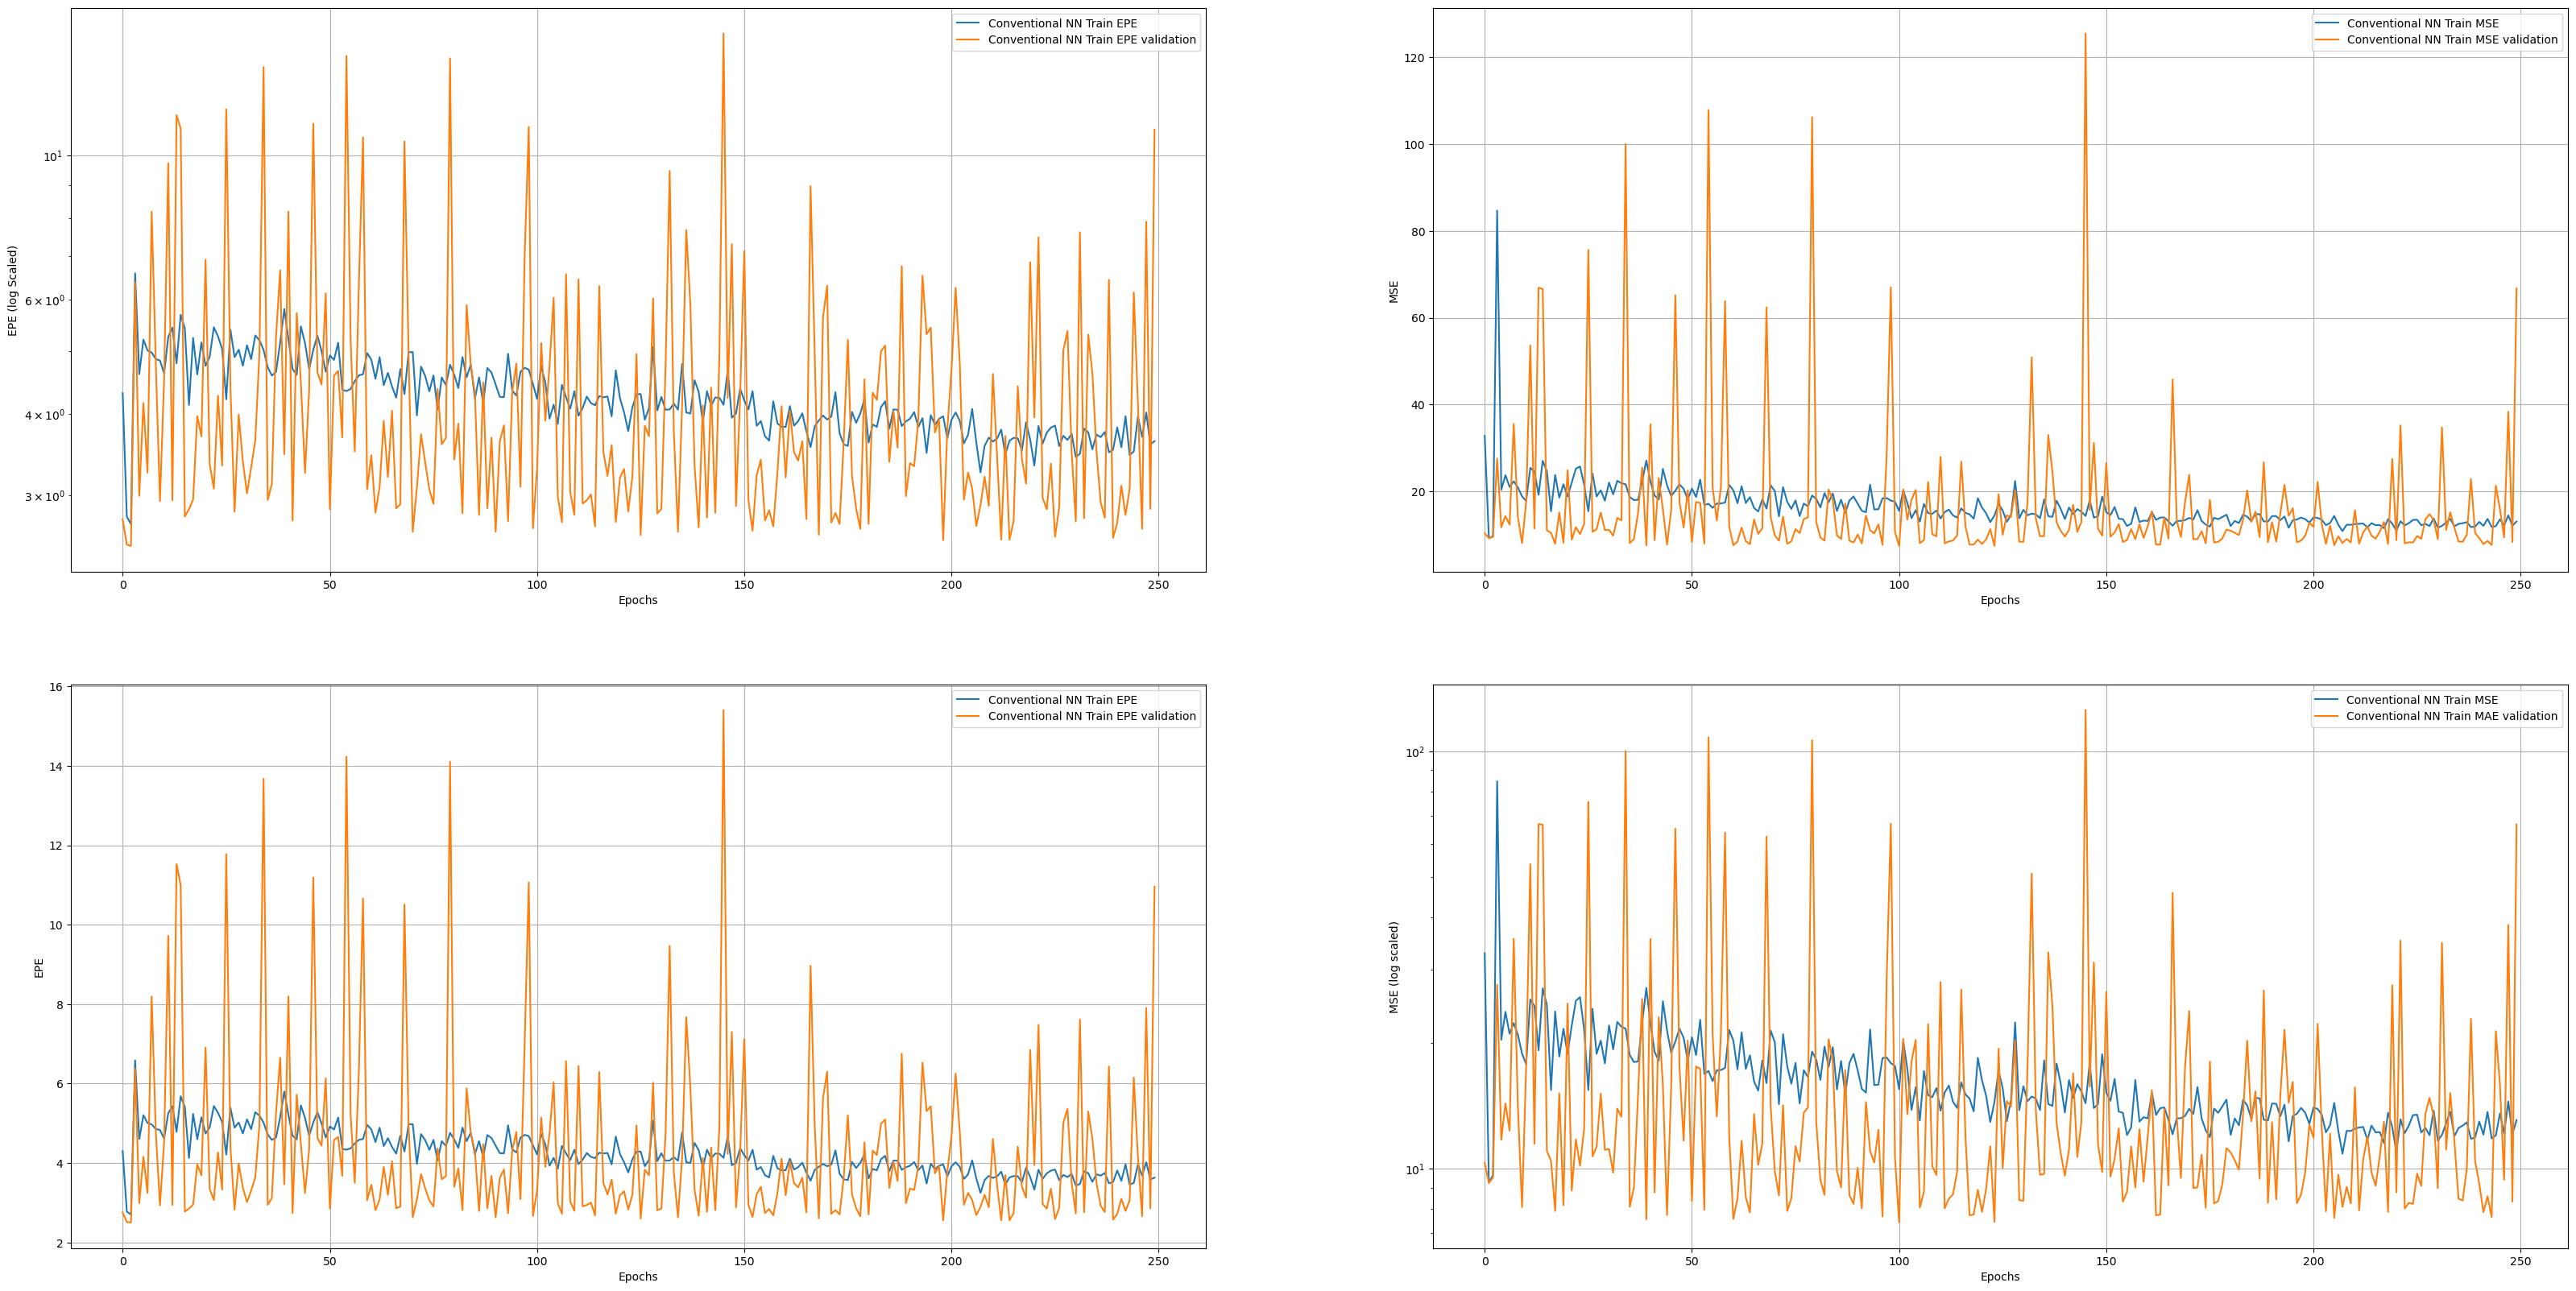

In [25]:
visualiseFits(hist)

In [26]:
onet.load_weights(modelPath)

In [27]:
preds = []
for i in tqdm(range(436)):
    row  = grid[i*1024:(i+1)*1024]
    out = onet.predict([first_broadcasted, row], batch_size=16, verbose = False)
    preds.append(out)

preds = np.array(preds)
print(preds.shape)

preds = preds.reshape(436, 1024, 2)
print(preds)

  0%|          | 0/436 [00:00<?, ?it/s]

100%|██████████| 436/436 [1:14:24<00:00, 10.24s/it]

(436, 1024, 2)
[[[-1.7129903   0.28652114]
  [-1.7058101   0.2873642 ]
  [-1.6977406   0.28860283]
  ...
  [-1.6523426   0.2941662 ]
  [-1.6529298   0.2940391 ]
  [-1.6513182   0.29428652]]

 [[-1.7392468   0.28297222]
  [-1.7106216   0.28743973]
  [-1.7148758   0.2868238 ]
  ...
  [-1.6513182   0.29428652]
  [-1.6513182   0.29428652]
  [-1.6513182   0.29428652]]

 [[-1.7266142   0.28509614]
  [-1.740576    0.28258324]
  [-1.7140006   0.28681004]
  ...
  [-1.6513182   0.29428652]
  [-1.6513182   0.29428652]
  [-1.6502938   0.29440677]]

 ...

 [[-1.8128341   0.27538097]
  [-1.8128341   0.27538097]
  [-1.8122449   0.2755084 ]
  ...
  [-1.8150395   0.27500552]
  [-1.8122449   0.2755084 ]
  [-1.8126826   0.27551526]]

 [[-1.8178344   0.27450264]
  [-1.8156288   0.27487805]
  [-1.8150395   0.27500552]
  ...
  [-1.8176827   0.27463692]
  [-1.8154771   0.27501237]
  [-1.8126826   0.27551526]]

 [[-1.8191473   0.27452326]
  [-1.8238442   0.27391353]
  [-1.8258982   0.27367243]
  ...
  [-1.821

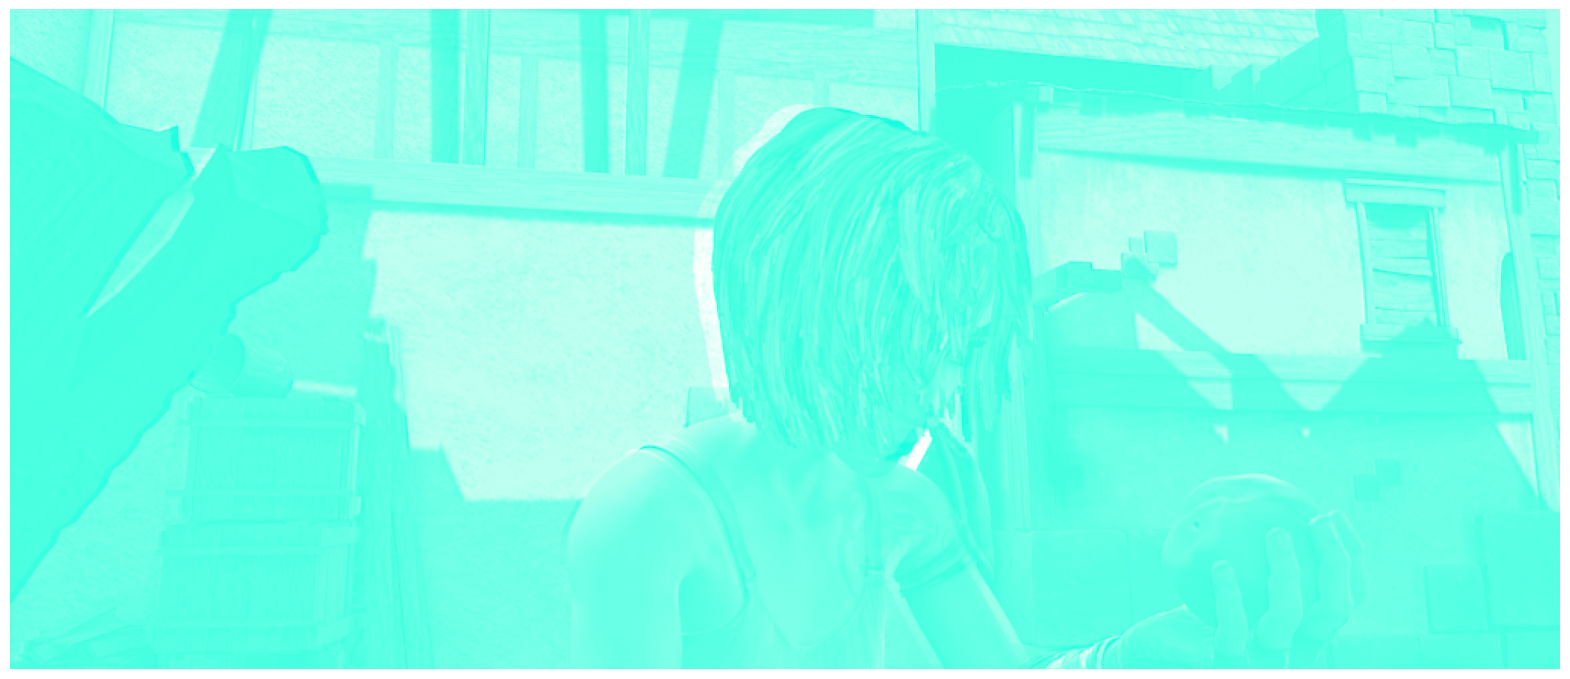

In [28]:
visualiser.visualiseOpticalFlow(preds)

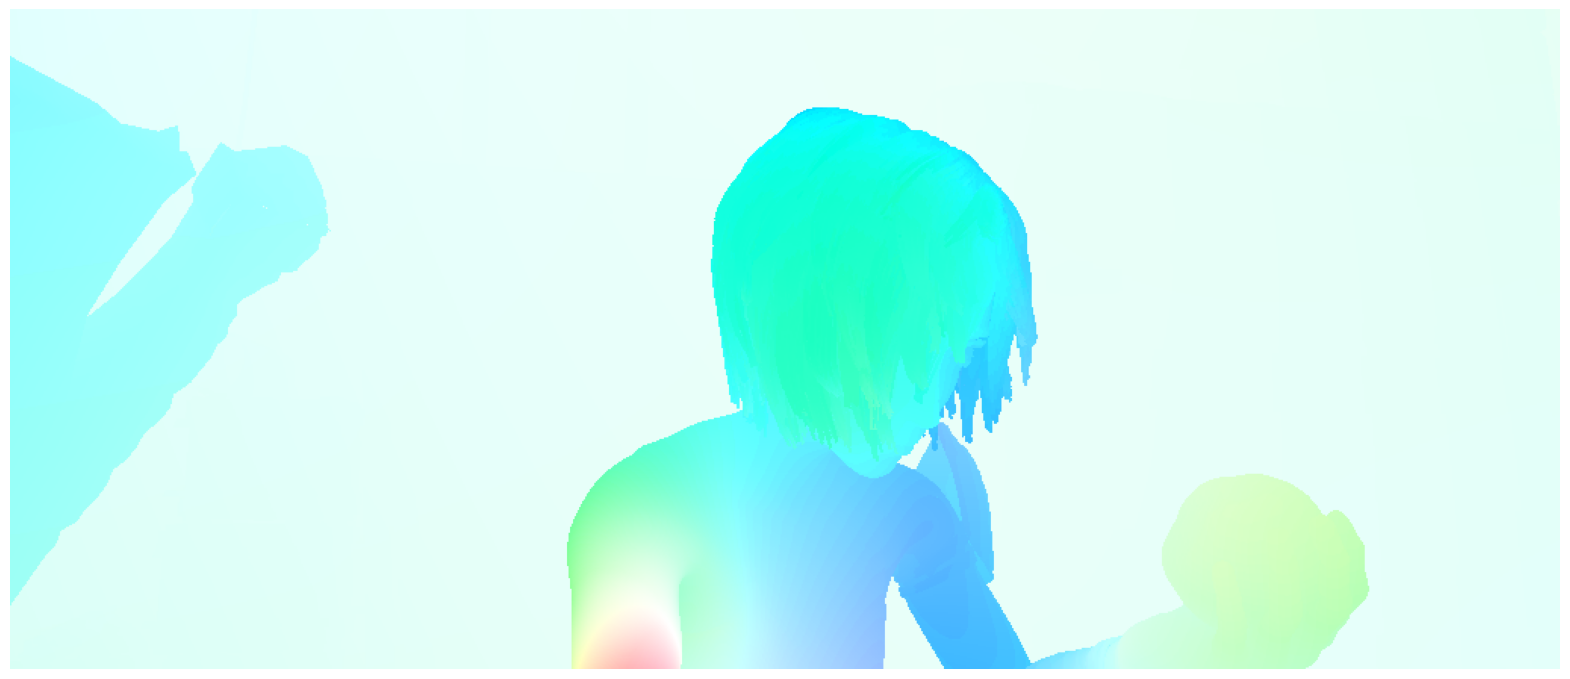

In [31]:
visualiser.visualiseOpticalFlow(train_y[index])

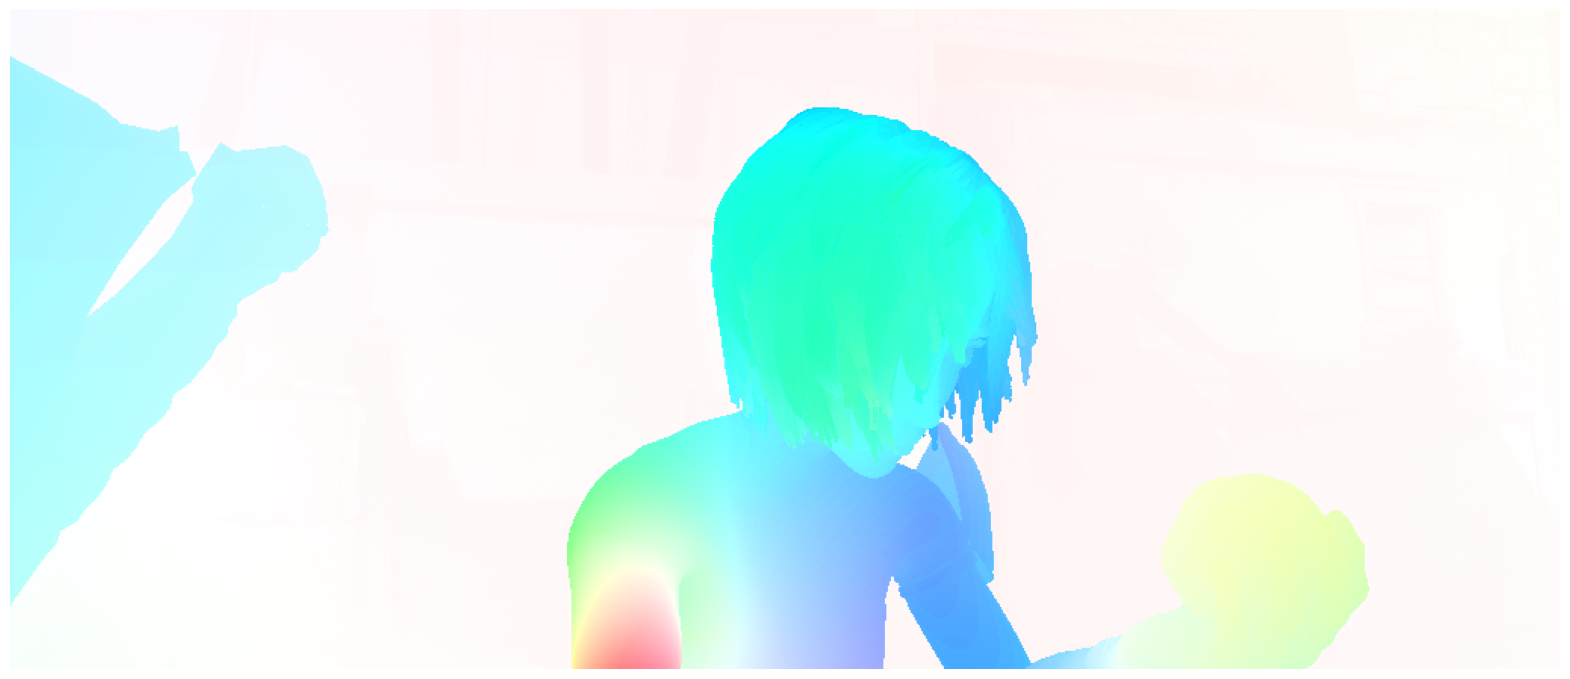

In [32]:
visualiser.visualiseFlowError(groundTruth=train_y[index], predicted=preds)